# **Analyse, transform, and evaluate the data downloaded**

In [56]:
import extract

In [57]:
import analyze

In [58]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
df_Mali_gauges, df_Mali_gauge_models, df_Mali_forecasts = analyze.get_country_data('Mali', '2024-07-08', '2024-10-08')
df_Kenya_gauges, df_Kenya_gauge_models, df_Kenya_forecasts = analyze.get_country_data('Kenya', '2024-07-10', '2024-10-08')
df_Zambia_gauges, df_Zambia_gauge_models, df_Zambia_forecasts = analyze.get_country_data('Zambia', '2024-07-12', '2024-10-08')

In [60]:
print(len(df_Mali_gauges), len(df_Mali_gauge_models), len(df_Mali_forecasts))
print(len(df_Kenya_gauges), len(df_Kenya_gauge_models), len(df_Kenya_forecasts))
print(len(df_Zambia_gauges), len(df_Zambia_gauge_models), len(df_Zambia_forecasts))

16 16 11776
3 3 2168
46 46 32384


In [61]:
df_Mali_forecasts.columns

Index(['gaugeId', 'issue_date', 'issue_time', 'fc_date', 'fc_value'], dtype='object')

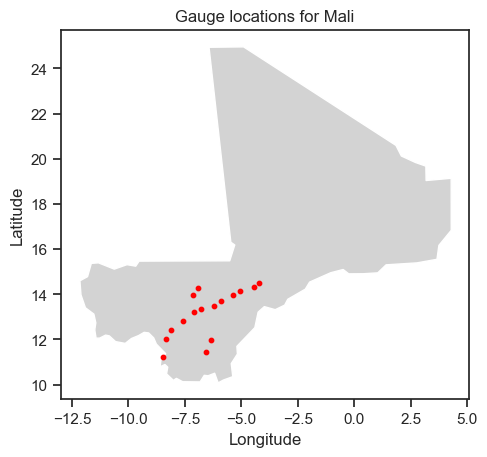

In [62]:
analyze.map_gauge_coordinates_of_country(
    df_Mali_gauges, 'Mali'
)

##### **Identify the gauges near the Niger river:**

In [63]:
df_Mali_gauge_coords = analyze.subset_country_gauge_coords(df_Mali_gauges)
print(df_Mali_gauge_coords)

             gaugeId   latitude  longitude
0   hybas_1120661040  13.985417  -7.152083
1   hybas_1121900350  13.685417  -5.893750
2   hybas_1120650110  14.277083  -6.927083
3   hybas_1121895840  13.956250  -5.360417
4   hybas_1120641660  14.506250  -4.206250
5   hybas_1121905290  13.360417  -6.789583
6   hybas_1120689830  13.210417  -7.077083
7   hybas_1120766460  11.222917  -8.485417
8   hybas_1120705070  12.835417  -7.581250
9   hybas_1120737100  12.018750  -8.322917
10  hybas_1121919510  12.410417  -8.106250
11  hybas_1121893090  14.131250  -5.039583
12  hybas_1120758950  11.427083  -6.581250
13  hybas_1121890140  14.314583  -4.422917
14  hybas_1120739110  11.977083  -6.360417
15  hybas_1120679780  13.493750  -6.202083


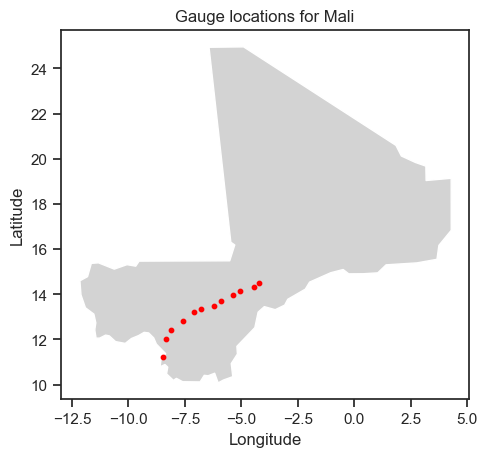

In [64]:
gauges_not_near_Niger = [
    'hybas_1120739110',
    'hybas_1120758950',
    'hybas_1120650110',
    'hybas_1120661040'
]

df_Mali_gauges_Niger = \
    df_Mali_gauges[~df_Mali_gauges['gaugeId'].isin(gauges_not_near_Niger)].copy()

analyze.map_gauge_coordinates_of_country(
    df_Mali_gauges_Niger, 'Mali'
)

In [65]:
df_Mali_gauges_Niger = df_Mali_gauges_Niger.sort_values(
    by = 'latitude',
    ascending = False).reset_index()
print(df_Mali_gauges_Niger['latitude'])

0     14.506250
1     14.314583
2     14.131250
3     13.956250
4     13.685417
5     13.493750
6     13.360417
7     13.210417
8     12.835417
9     12.410417
10    12.018750
11    11.222917
Name: latitude, dtype: float64


No forecasted values for gauge hybas_1120661040 at 2024-08-09


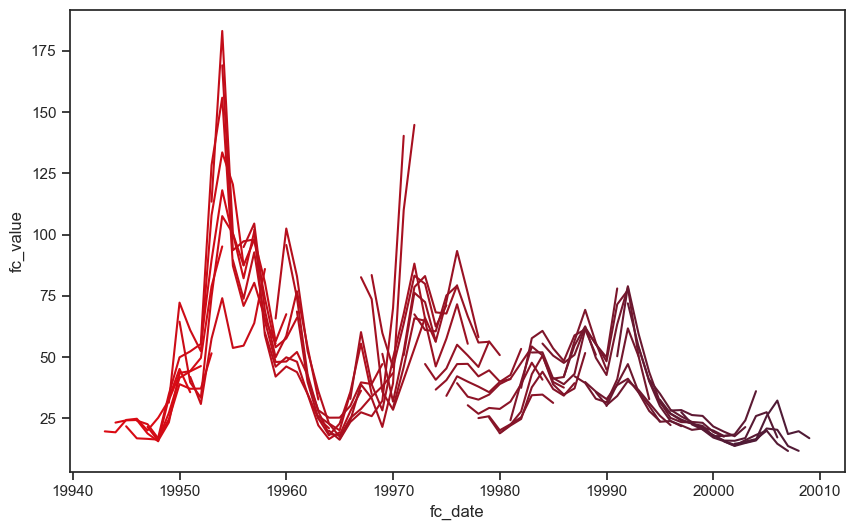

In [66]:
start_date = datetime.datetime.now() - datetime.timedelta(days = 90)

analyze.plot_x_days_of_gauge_forecast_for_issue_time(
    df_Mali_forecasts,                      # plot for Mali
    df_Mali_gauges['gaugeId'].to_list()[0], # plot for the first gauge
    start_date,                             # plot starts 90 days ago (relative to today)
    90,                                     # plot for 90 days (relative to start date)                                                  
    'Mali',                                 # country name (don't forget the capital letter)
)

# **Explorative statistics**

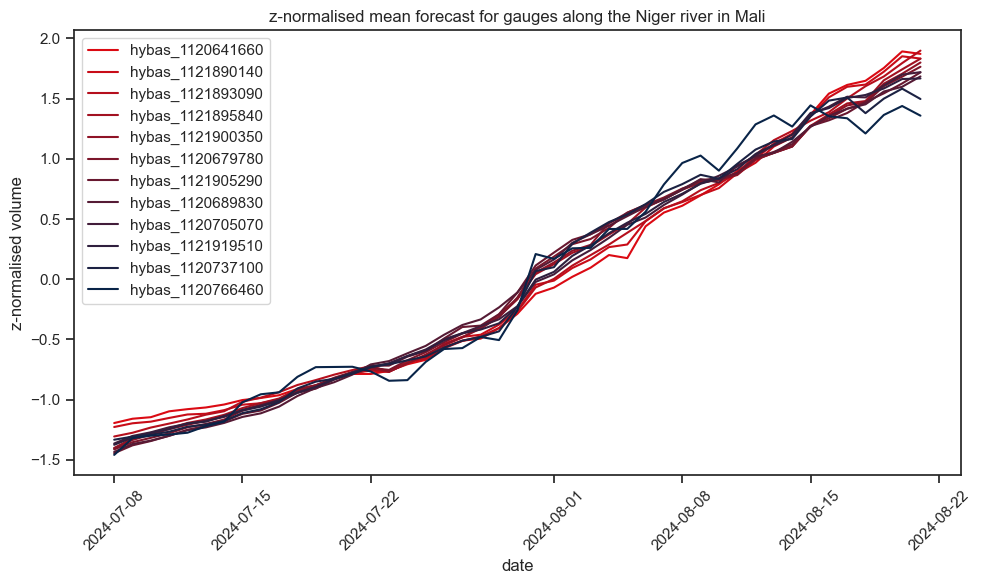

In [67]:
analyze.plot_Niger_river_downstream_flow_stat(
    df_Mali_forecasts,
    datetime.datetime(2024, 7, 8, 0, 0),
    df_Mali_gauges_Niger['gaugeId'].to_list(),
    45,
    'mean'
)

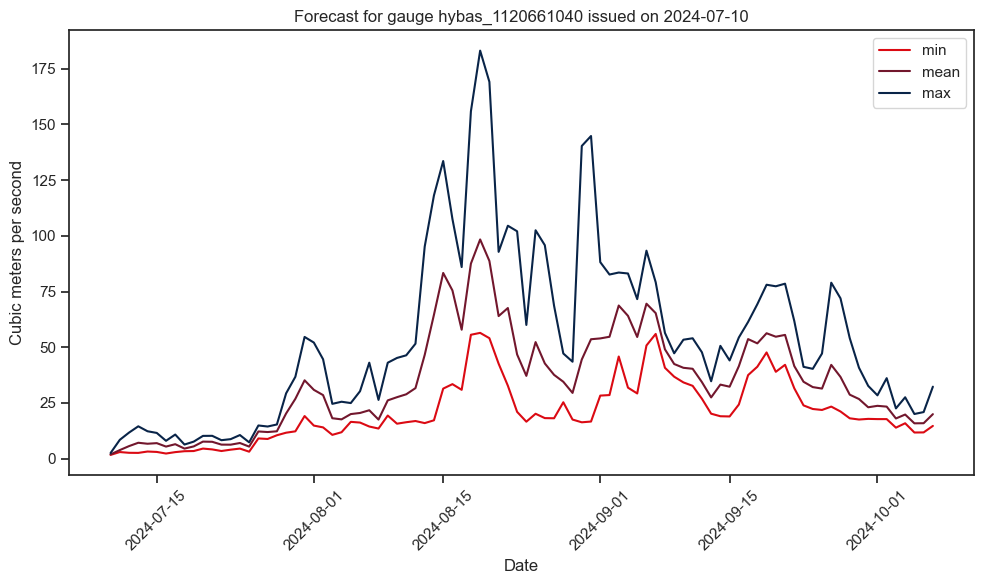

In [68]:
issue_time = datetime.datetime(2024, 10, 8, 0, 0) - datetime.timedelta(days = 90)

analyze.plot_forecast_min_mean_max(
    df_Mali_forecasts,                      # the forecasts
    issue_time,                             # the issue time
    df_Mali_gauges['gaugeId'].to_list()[0], # the gauge
    90                                      # the number of days
)

# **Station-to-administrative-unit classification**

In [86]:
import geopandas as gpd

path_Mali_shp_adm2 = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp'
gpd_adm_units_Mali = analyze.get_shape_file(path_Mali_shp_adm2).to_crs('EPSG:4326')
print(type(gpd_adm_units_Mali))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [95]:
gpd_Mali_gauge_coords = gpd.GeoDataFrame(
    df_Mali_gauge_coords,
    geometry = gpd.points_from_xy(df_Mali_gauge_coords.longitude, df_Mali_gauge_coords.latitude),
    crs = 'EPSG:4326'
)
print(type(gpd_Mali_gauge_coords))

# Check if the crs of the two GeoDataFrames are the same
if gpd_adm_units_Mali.crs != gpd_Mali_gauge_coords.crs:
    gpd_adm_units_Mal = gpd_adm_units_Mali.to_crs(gpd_Mali_gauge_coords.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>


In [96]:
gpd_gauges_classified = gpd.sjoin(
    gpd_Mali_gauge_coords,
    gpd_adm_units_Mali,
    how = 'left', # joins left, i.e. the gauges serve as basis
    predicate = 'within', # checks if the gauge is within the admin unit
    lsuffix = 'gauge',
    rsuffix = 'adm'
)

print(type(gpd_gauges_classified))
print(gpd_gauges_classified.head(2))

<class 'geopandas.geodataframe.GeoDataFrame'>
            gaugeId   latitude  longitude                   geometry  \
0  hybas_1120661040  13.985417  -7.152083  POINT (-7.15208 13.98542)   
1  hybas_1121900350  13.685417  -5.893750  POINT (-5.89375 13.68542)   

   index_adm  Shape_Leng  Shape_Area  ADM2_FR ADM2_PCODE ADM2_REF ADM2ALT1FR  \
0        7.0    4.526434    0.657252  Banamba     ML0201     None       None   
1       26.0    6.342597    1.318047    Ségou     ML0406    Segou       None   

  ADM2ALT2FR    ADM1_FR ADM1_PCODE    ADM0_FR ADM0_PCODE       date  \
0       None  Koulikoro       ML02  Mali (le)         ML 2015-06-01   
1       None      Ségou       ML04  Mali (le)         ML 2015-06-01   

     validOn     validTo  
0 2021-12-20  0000/00/00  
1 2021-12-20  0000/00/00  


In [89]:
# Save as GEOJSON
gpd_gauges_classified.to_file(
    '../data/processed/gauge_adm_units/mali_gauges_adm_units.geojson',
    driver = 'GeoJSON'
)

In [90]:
# Load GEOJSON back in
gpd_gauges_classified = gpd.read_file(
    '../data/processed/gauge_adm_units/mali_gauges_adm_units.geojson'
)

In [98]:
print(type(gpd_adm_units_Mali))
print(type(gpd_Mali_gauge_coords))
print(gpd_adm_units_Mali.index)
print(gpd_adm_units_Mali.columns)
print(gpd_Mali_gauge_coords.index)
print(gpd_Mali_gauge_coords.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex(start=0, stop=53, step=1)
Index(['Shape_Leng', 'Shape_Area', 'ADM2_FR', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1FR', 'ADM2ALT2FR', 'ADM1_FR', 'ADM1_PCODE', 'ADM0_FR',
       'ADM0_PCODE', 'date', 'validOn', 'validTo', 'geometry'],
      dtype='object')
RangeIndex(start=0, stop=16, step=1)
Index(['gaugeId', 'latitude', 'longitude', 'geometry'], dtype='object')


In [101]:
# Plot the gauges and the admin units
# with every admin unit with a gauge tinted in red

gpd_adm_units_matched = gpd.sjoin(
    gpd_adm_units_Mali,
    gpd_Mali_gauge_coords,
    how = 'left',
    predicate = 'contains',
    # lsuffix = 'adm',
    # rsuffix = 'gauge'
)

print(len(gpd_adm_units_matched))
adm_units_with_gauges = gpd_adm_units_matched.dropna(subset = ['index_right'])['index'].unique()
print(len(gpd_adm_units_matched))



# fig, ax = plt.subplots(figsize = (10, 10))
# adm_units_Mali.plot(ax = ax, color = 'lightgrey')
# gdf_Mali_gauge_coords.plot(ax = ax, color = 'red')
# plt.show()

58


KeyError: 'index'

# **Calculate Niger cross-correlation and propagation time**

Some issues:
- Is detrending needed? Or, partly, in other words, is the non-stationarity a problem?
- The stations are not spatially evenly distributed, is this OK?

In [19]:
df_Mali_forecasts

,gaugeId,issue_date,issue_time,fc_date,fc_value
0,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-07,238.515350
1,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-08,247.505783
2,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-09,249.693771
3,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-10,255.613663
4,hybas_1120641660,2024-07-08,2024-07-08 13:54:03.433896+00:00,2024-07-11,272.268463
...,...,...,...,...,...
11771,hybas_1121893090,2024-10-07,2024-10-07 08:51:23.103906+00:00,2024-10-09,3385.522461
11772,hybas_1121893090,2024-10-07,2024-10-07 08:51:23.103906+00:00,2024-10-10,3410.729004
11773,hybas_1121893090,2024-10-07,2024-10-07 08:51:23.103906+00:00,2024-10-11,3454.612305
11774,hybas_1121893090,2024-10-07,2024-10-07 08:51:23.103906+00:00,2024-10-12,3498.025391
